In [1]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        #left = int(crops['left'])-int(crops['width'])*0.25
        #top = int(crops['top'])-int(crops['height'])*0.25
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])
        case = "144"
        if case == "100" :
            if(width>height):
                top = top + 0.5*height - 0.5*width
                height = width
            else :
                left = left +0.5*width - 0.5*height
                width = height
        elif case =="150" :
            if(width > height) :
                left = left - width*0.25
                top = top + height*0.5 - width*0.5 - width*0.25
                width = width*1.5
                height = width
            else :
                top = top - height*0.25
                left = left + width*0.5 - height*0.5 - height*0.25
                height = height*1.5
                width = height
        elif case =="144" :
            side = (width*height)**0.5
            top = top+height-side
            left = left+0.5*width-0.5*side
            width = side
            height = side
                
        image = TF.crop(image, top, left, height, width)
        
        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        
        return image, landmarks

In [3]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        #tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        tree = ET.parse('./300W_LP/labels_300W_LP.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        #self.root_dir = 'ibug_300W_large_face_landmark_dataset'
        self.root_dir= './300W_LP'
        
        for filename in root[0]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

dataset = FaceLandmarksDataset(Transforms())

In [4]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=0)

The length of Train set is 90714
The length of Valid set is 10079


In [5]:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18(pretrained=True) # from vol.6
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [6]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [7]:
torch.autograd.set_detect_anomaly(True)
network = Network()
network.cuda()    

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 10

start_time = time.time()
for epoch in range(1,num_epochs+1):
    epoch_time = time.time()
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):
    
        images, landmarks = next(iter(train_loader))
        
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
        
        predictions = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'LandmarkModel_9_wingLoss.pth') # _0 : without edit, _1 : with squrare, _2 : 150% enlarged square 
                                                                #_3 : 150% enlarged properly(left and top points altered)
                                                                #_4 : 150% enlarged really properly...(Crop funct omitted)
                                                                #_5 : 150%...(Epoch: 10  Train Loss: 0.0011  Valid Loss: 0.0016, 7920s)
                                                                #_6 : use pretrained-model(Minimum Validation Loss of 0.0008 8190s)
                                                                #_7: square (Minimum Validation Loss of 0.0020 at epoch 7/10 7228s)
                                                                #_8 : same area (0.0028 7530s)
                                                                #_9 : same area with wingLoss( 0.0013)
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
        print("Total Elapsed Time : {} s".format(time.time()-epoch_time))
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

Valid Steps: 1260/1260  Loss: 0.0058 
--------------------------------------------------
Epoch: 1  Train Loss: 0.0099  Valid Loss: 0.0058
--------------------------------------------------

Minimum Validation Loss of 0.0058 at epoch 1/10
Model Saved

Total Elapsed Time : 1150.6394214630127 s
Valid Steps: 1260/1260  Loss: 0.0043 
--------------------------------------------------
Epoch: 2  Train Loss: 0.0043  Valid Loss: 0.0043
--------------------------------------------------

Minimum Validation Loss of 0.0043 at epoch 2/10
Model Saved

Total Elapsed Time : 1157.4154932498932 s
Valid Steps: 1260/1260  Loss: 0.0027 
--------------------------------------------------
Epoch: 3  Train Loss: 0.0026  Valid Loss: 0.0027
--------------------------------------------------

Minimum Validation Loss of 0.0027 at epoch 3/10
Model Saved

Total Elapsed Time : 1115.5748252868652 s
Valid Steps: 1260/1260  Loss: 0.0024 
--------------------------------------------------
Epoch: 4  Train Loss: 0.0019  Va

Total number of test images: 10079
Elapsed Time : 0.4627673625946045


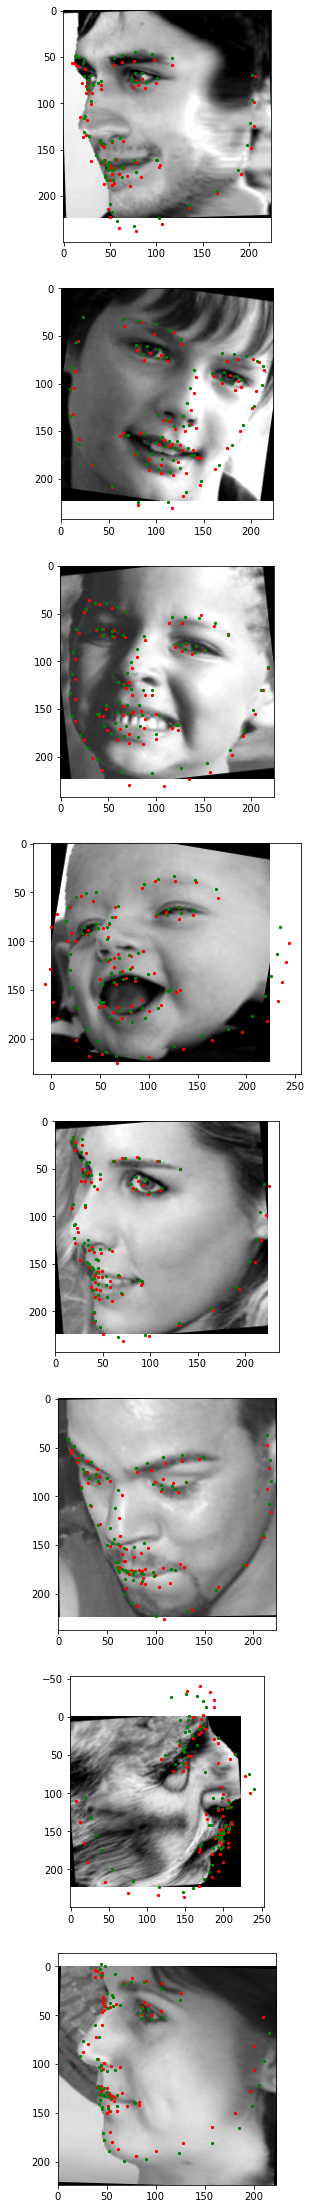

In [37]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('./LandmarkModel_9_wingLoss.pth'))
    best_network.eval()
    
    images, landmarks = next(iter(valid_loader))
    images = images.cuda()
    landmarks = (landmarks + 0.5) * 224

    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1,68,2)
    
    plt.figure(figsize=(10,40))
    
    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        #print(images[img_num].cpu().numpy().shape)
        #print(images[img_num].cpu().numpy().transpose(1,2,0).shape)
        #print(images[img_num].cpu().numpy().transpose(1,2,0).squeeze().shape)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 

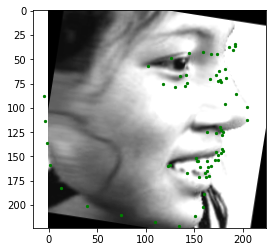

In [36]:
plt.imshow(images[0].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
plt.scatter(landmarks[0,:,0], landmarks[img_num,:,1], c = 'g', s = 5)